In [1]:
import sys
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
sys.path.append("..")
from mango.environments import frozen_lake
import utils
import torch
from typing import Any, NamedTuple
import optuna
import numpy as np
import warnings

In [2]:
from mango.mango import MangoEnv, Agent
from mango.policies.experiencereplay import ExperienceReplay
from mango.policies.dqnet import DQNetTrainer, DQNetPolicy

In [3]:
class AnnealingStrategy(NamedTuple):
    episodes: int
    epsilon: float

    def randomness(self, i: int) -> float:
        if i > self.episodes:
            return self.epsilon
        return 1.0 - (1.0 - self.epsilon) * i / self.episodes
        

class LazyConvEncoder(torch.nn.Sequential):
    def __init__(self, hidden, out):
        with warnings.catch_warnings():
            def cell(channels):
                return torch.nn.Sequential(
                    torch.nn.LazyConv2d(channels, 3, padding=1),
                    torch.nn.GELU(),
                    torch.nn.LazyConv2d(channels, 2, stride=2),
                    torch.nn.BatchNorm2d(channels),
                )
            warnings.simplefilter("ignore") # ignore LazyModule warning
            super().__init__(
                *(cell(channels) for channels in hidden),
                torch.nn.Flatten(),
                torch.nn.LazyLinear(out),
            )

In [4]:
train_device = torch.device("cuda")
scale = 3
max_steps = 100000

map_size = 2**scale
params: dict[str, Any] = dict(
    map_name=f"{map_size}x{map_size}",
    p=None,
    shape=(map_size, map_size),
    seed=42,
)


def run(trial):
    env = frozen_lake.wrappers.TensorObservation(
        frozen_lake.wrappers.ReInitOnReset(frozen_lake.CustomFrozenLakeEnv(**params), **params),
        one_hot=True,
    )
    net = LazyConvEncoder(hidden=[2**scale] * scale, out=int(env.action_space.n)).eval()
    policy = DQNetPolicy(net, env.action_space)
    trainer = DQNetTrainer(net, lr=1e-3, gamma=0.95, tau=0.01)
    replay = ExperienceReplay(256, capacity=2**13)
    agent = Agent(MangoEnv(env), policy)

    eval_reward_log = [0.0]
    expl_reward_log = [0.0]
    lenght_log = [0]
    loss_log = []

    max_loops = trial.suggest_int("max_loops", 1, 10, log=True)
    annealing = AnnealingStrategy(
        episodes=trial.suggest_int("warmup_steps", max_steps // 10, max_steps // 2, log=True),
        epsilon=trial.suggest_float("epsilon", 0.01, 0.5, log=True),
    )

    interactions = 0
    accuracy = 0.0
    with tqdm(total=max_steps, leave=False) as pbar:
        while interactions < max_steps:
            # evaluation
            trans = agent.run_episode(randomness=0.0)
            eval_reward_log.append(trans.reward)

            # exploration
            trans = agent.run_episode(annealing.randomness(interactions), max_loops)
            replay.extend(trans.steps)
            expl_reward_log.append(trans.reward)
            lenght_log.append(len(trans.trajectory))

            # report
            interactions = sum(lenght_log)
            accuracy = np.trapz(eval_reward_log, np.cumsum(lenght_log)) / max_steps
            if accuracy >= 0.2:
                trial.report(1.0, step=max_steps)
                return accuracy + (max_steps - interactions) / max_steps

            trial.report(accuracy, step=interactions)
            if trial.should_prune():
                raise optuna.TrialPruned()

            # logging
            pbar.update(len(trans.trajectory))
            pbar.set_description(f"reward: {accuracy:.2f}")

            # training
            if replay.can_sample():
                transitions = replay.sample(device=train_device)
                trainer.net.to(train_device, non_blocking=True)
                train_info = trainer.train(transitions)
                replay.update_priorities_last_sampled(train_info.td)
                trainer.net.to("cpu", non_blocking=True)
                loss_log.append(train_info.loss)
            # if cuda syncronize to make sure all nets are back on cpu
            if train_device.type == "cuda":
                torch.cuda.synchronize(train_device)
        return accuracy

In [5]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(run, n_jobs=2, n_trials=16, show_progress_bar=True)

[I 2024-01-20 19:25:10,769] A new study created in memory with name: no-name-73577357-3ab8-46b2-b1bc-7bb4dcd964f6


  0%|          | 0/16 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-01-20 19:27:26,179] Trial 0 finished with value: 0.0 and parameters: {'max_loops': 10, 'warmup_steps': 1005, 'epsilon': 0.01864679040506992}. Best is trial 0 with value: 0.0.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-01-20 19:27:32,654] Trial 2 finished with value: 0.0 and parameters: {'max_loops': 7, 'warmup_steps': 4675, 'epsilon': 0.014498201771902296}. Best is trial 0 with value: 0.0.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-01-20 19:27:34,079] Trial 3 finished with value: 0.0 and parameters: {'max_loops': 6, 'warmup_steps': 1651, 'epsilon': 0.04710680563925125}. Best is trial 0 with value: 0.0.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-01-20 19:28:48,585] Trial 1 finished with value: 0.0 and parameters: {'max_loops': 1, 'warmup_steps': 3028, 'epsilon': 0.057856551573320245}. Best is trial 0 with value: 0.0.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-01-20 19:29:59,801] Trial 5 finished with value: 0.0 and parameters: {'max_loops': 10, 'warmup_steps': 1992, 'epsilon': 0.1391916726921297}. Best is trial 0 with value: 0.0.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2024-01-20 19:30:06,415] Trial 6 finished with value: 0.0 and parameters: {'max_loops': 9, 'warmup_steps': 1274, 'epsilon': 0.03069620237137125}. Best is trial 0 with value: 0.0.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["epsilon", "warmup_steps", "max_loops"])
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

FrozenTrial(number=0, state=1, values=[0.6820999999999999], datetime_start=datetime.datetime(2024, 1, 20, 19, 10, 1, 361903), datetime_complete=datetime.datetime(2024, 1, 20, 19, 12, 7, 42327), params={'max_loops': 1, 'warmup_steps': 4354, 'epsilon': 0.019644426287212947}, user_attrs={}, system_attrs={}, intermediate_values={3: 0.0, 6: 0.0, 11: 0.0, 15: 0.0, 21: 0.0, 24: 0.0, 28: 0.0, 32: 0.0, 35: 0.0, 38: 0.0, 43: 0.0, 46: 0.0, 49: 0.0, 53: 0.0, 56: 0.0, 59: 0.0, 63: 0.0, 68: 0.0, 74: 0.0, 78: 0.0, 88: 0.0, 91: 0.0, 94: 0.0, 101: 0.0, 105: 0.0, 108: 0.0, 114: 0.0, 118: 0.0, 121: 0.0, 127: 0.0, 134: 0.0, 138: 0.0, 141: 0.0, 144: 0.0, 150: 0.0, 157: 0.0, 163: 0.0, 167: 0.0, 171: 0.0, 174: 0.0, 180: 0.0, 183: 0.0, 188: 0.0, 193: 0.0, 196: 0.0, 200: 0.0, 203: 0.0, 206: 0.0, 209: 0.0, 212: 0.0, 217: 0.0, 223: 0.0, 227: 0.0, 230: 0.0, 233: 0.0, 238: 0.0, 241: 0.0, 244: 0.0, 247: 0.0, 251: 0.0, 255: 0.0, 258: 0.0, 262: 0.0, 265: 0.0, 270: 0.0, 273: 0.0, 277: 0.0, 281: 0.0, 285: 0.0, 293: 0.0

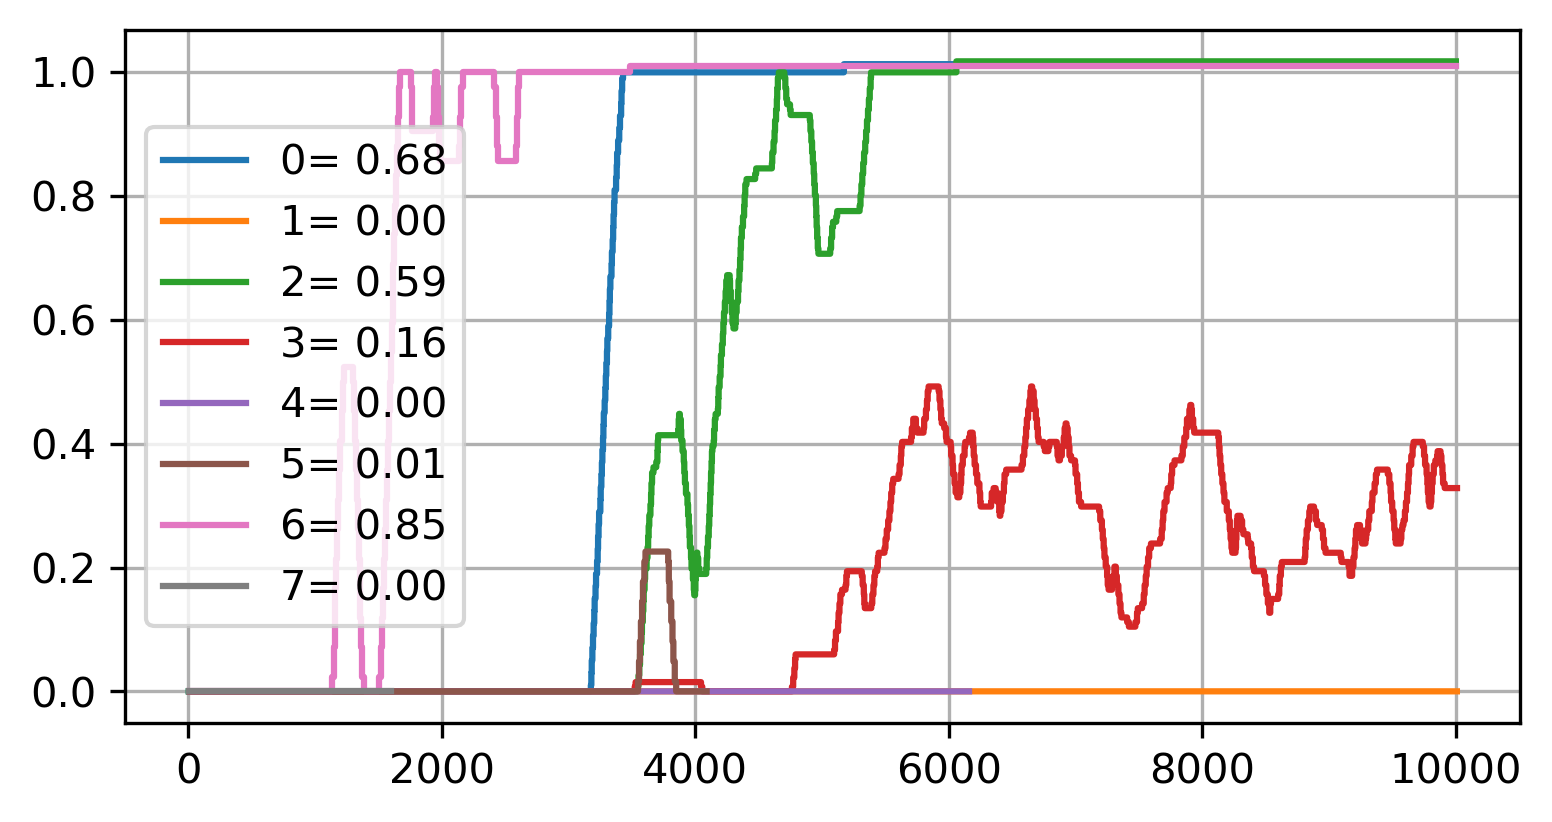

In [ ]:
plt.figure(figsize=(6,3), dpi=300)
for trial in study.trials:
    if trial.value < 0.5:
        continue
    avg_reward = list(trial.intermediate_values.values())
    iterations = list(trial.intermediate_values.keys())
    deltay = [next-prev for next, prev in zip(avg_reward[1:], avg_reward[:-1])]
    deltax = [next-prev for next, prev in zip(iterations[1:], iterations[:-1])]
    reward_per_step = utils.smooth([dy/dx*max_steps for dy, dx in zip(deltay, deltax)], 0.05)
    plt.step(iterations[1:], reward_per_step[:], label=f"{trial.number}= {trial.value:.2f}")
plt.legend()
plt.grid()